**Collection Mapper**

This module will assist MV collection system layout design and output a KML file.

> Troubleshooting: Run each cell to locate the error. Remove comments before print statements to see if data structures correctly reflect the input data. 

> Editing: Reference Networkx, SimpleKML, and Python documentation for help making changes. Ask ChatGPT for support as needed.

First-time users will need to import the following libraries: Networkx, Matplotlib, Numpy, and SimpleKML. Remove single quotes and run the following cell to download the necessary libraries.

In [ ]:
'''
import pip
pip.main(["install", "networkx"])
pip.main(["install", "matplotlib"])
pip.main(["install", "numpy"])
pip.main(["install", "simplekml"])
'''

**Export CSV data from Global Mapper.**

The first row should contain column titles-- defaults are fine as the data will be removed. The first column should contain WTG & substation names, the second column should contain latitude values, and the third column should contain longitude values. 

Change the name of the file called by the open() function in the cell below to match the name of your file. 

In [9]:
# Read CSV into a list format
import csv
wtg_init = []
with open('wtgdata_nimbus.csv') as data:
    D = csv.reader(data, delimiter = ",")
    for row in D:
        wtg_init.append(row)
wtg_init = wtg_init[1:]
print(wtg_init)

# Format lat/long data: check for quadrant and change type to float
# Create a dictionary data structure to hold coordinates for each point
# Ex. ['S00', '95.13234222? W', '42.00511659? N'] becomes {'S00': (-95.13234222, 42.00511659)}
if 'W' in wtg_init[1][1]:
    if 'N' in wtg_init[1][2]:
        for i in wtg_init:
            i[1] = -1*float(i[1].split('?')[0])
            i[2] = float(i[2].split('?')[0])
    else:
        for i in wtg_init:
            i[1] = -1*float(i[1].split('?')[0])
            i[2] = -1*float(i[2].split('?')[0])
else:
    if 'N' in wtg_init[1][2]:
        for i in wtg_init:
            i[1] = float(i[1].split('?')[0])
            i[2] = float(i[2].split('?')[0])
    else:
        for i in wtg_init:
            i[1] = float(i[1].split('?')[0])
            i[2] = -1*float(i[2].split('?')[0])

pos_dict = {}
for i in wtg_init:
    pos_dict[i[0]] = (float(i[1]),float(i[2]))
print(pos_dict)

[['S0', '93.40063433? W', '36.25723845? N'], ['T10', '93.41071018? W', '36.27964444? N'], ['T11', '93.40545441? W', '36.27900629? N'], ['T13', '93.35904900? W', '36.28361700? N'], ['T14', '93.42213179? W', '36.27368872? N'], ['T15', '93.41828646? W', '36.27016105? N'], ['T17', '93.38457510? W', '36.27144538? N'], ['T18', '93.36848300? W', '36.27777500? N'], ['T19', '93.36432200? W', '36.27416800? N'], ['T2', '93.43481452? W', '36.29534753? N'], ['T20', '93.35916800? W', '36.27438500? N'], ['T22', '93.35566113? W', '36.27025091? N'], ['T23', '93.41360381? W', '36.26263961? N'], ['T24', '93.39288321? W', '36.26754885? N'], ['T25', '93.38949400? W', '36.26539700? N'], ['T26', '93.38493493? W', '36.26306257? N'], ['T27', '93.37957222? W', '36.26146776? N'], ['T28', '93.37597747? W', '36.26046992? N'], ['T29', '93.37153641? W', '36.26030315? N'], ['T30', '93.36712861? W', '36.26077567? N'], ['T31', '93.36270805? W', '36.26300670? N'], ['T32', '93.35774687? W', '36.26365834? N'], ['T33', '93

Graphs are provided in the following steps to assist your WTG groupings. 

Run all cells even if you already have groupings in mind. 

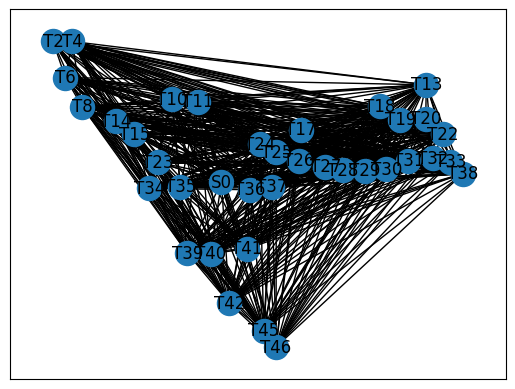

In [10]:
# Create a weighted graph of all possible turbine connections. 
# Weights are calculated as distances between points. 
wtg_network = []
for i in wtg_init:
    for j in wtg_init:
        flag = 0
        if i != j:
            distance =( (float(i[1])-float(j[1]))**2 + (float(i[2])-float(j[2]))**2 )**0.5
            for k in wtg_network:
                if k[0] == j[0] and k[1] == i[0]:
                    flag = 1
            if flag == 0:
                wtg_network.append([i[0],j[0],distance])

import networkx as nx
G = nx.Graph()
G.add_weighted_edges_from(wtg_network)

nx.draw_networkx(G, pos=pos_dict, with_labels=True)

Creates clusters by iterating through the list of nodes, and adding closest nodes to each cluster. 

Dijstraka's algorithm is used to find shortest path lengths. 

Initial clusters selected will be contain close neighbors, and then cluster quality will deteriorate as the pool of remaining nodes decreases.

['T8', 'T14', 'T15', 'T10', 'T23']
['T13', 'T20', 'T19', 'T18', 'T22']
['T26', 'T25', 'T24', 'T17', 'T27']
['T34', 'T35', 'S0', 'T36', 'T37']
['T38', 'T33', 'T32', 'T31', 'T30']
['T40', 'T39', 'T41', 'T42', 'T45']
['T6', 'T4', 'T2', 'T11', 'T28']
['T29', 'T46']


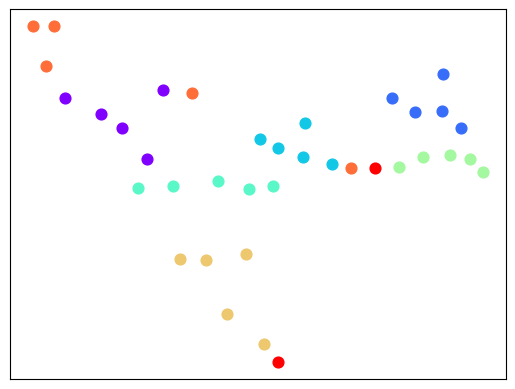

In [13]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def cluster_nodes(graph, cluster_size=5):
    # Get the list of nodes
    nodes = list(graph.nodes)
    num_clusters = len(nodes) // cluster_size
    
    # Compute the shortest path lengths between all pairs of nodes
    length_dict = dict(nx.all_pairs_dijkstra_path_length(graph))
    
    # Convert the shortest path lengths into a distance matrix
    distances = np.zeros((len(nodes), len(nodes)))
    for i, node_i in enumerate(nodes):
        for j, node_j in enumerate(nodes):
            distances[i, j] = length_dict[node_i][node_j]
    
    clusters = []
    unassigned_nodes = set(nodes)
    
    while unassigned_nodes:
        # Start a new cluster
        cluster = []
        
        # Randomly pick a node to start the cluster
        current_node = unassigned_nodes.pop()
        cluster.append(current_node)
        
        while len(cluster) < cluster_size and unassigned_nodes:
            # Find the closest unassigned node to the current cluster
            closest_node = None
            closest_distance = float('inf')
            
            for node in unassigned_nodes:
                distance = sum(distances[nodes.index(node)][nodes.index(cn)] for cn in cluster)
                if distance < closest_distance:
                    closest_distance = distance
                    closest_node = node
            
            # Add the closest node to the cluster
            if closest_node:
                unassigned_nodes.remove(closest_node)
                cluster.append(closest_node)
        print(cluster)
        clusters.append(cluster)
    
    return clusters


no_sub = wtg_network
no_sub = no_sub[1:]
G_t = nx.Graph()
G_t.clear()
G_t.add_weighted_edges_from(no_sub)
clusters = cluster_nodes(G_t, cluster_size=5)
#print(clusters)

colors = plt.cm.rainbow(np.linspace(0,1,len(clusters)))
for cluster, color in zip(clusters, colors):
    nx.draw_networkx_nodes(no_sub,pos=pos_dict, nodelist = cluster, node_color = [color], node_size=60)

A minimum spanning tree connects all points along the shortest possible path.

By default, the function uses Kruskal's Algorithm. To use Prim's Algorithm, specify algorithm='prim'.

Minimum Spanning Tree


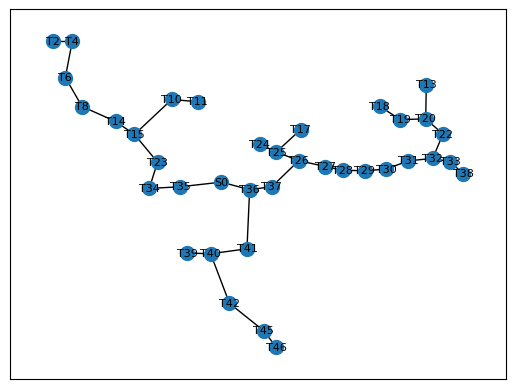

In [14]:
print("Minimum Spanning Tree")
y = nx.minimum_spanning_tree(G)
nx.draw_networkx(y, pos=pos_dict, with_labels=True, node_size=100, font_size = 8)

**Input WTG Groups**

Calculate how many WTG's can be connected to each feeder.
For projects with multiple MPT's, put a balanced number of WTG's on each side.

>The names of the turbines and substation must match the names from the CSV file.

In [5]:
# Name of substation point:
sub = 'S00'

# Input collection system here:
collection = {}
collection['11A'] = [sub, 'T09', 'T06', 'T02', 'T03', 'T01']
collection['11B'] = [sub, 'T16', 'T18', 'T08', 'T05']
collection['12A'] = [sub, 'T28', 'T24', 'T22', 'T21', 'T20']
collection['12B'] = [sub, 'T30', 'T29', 'T27', 'T26', 'T25']
collection['13A'] = [sub, 'T31', 'T43', 'T40', 'T85', 'T86']
collection['13B'] = [sub, 'T44', 'T46', 'T80', 'T65', 'T66']

collection['21A'] = [sub, 'T83', 'T10', 'T11', 'T12']
collection['21B'] = [sub, 'T32', 'T33', 'T35', 'T15', 'T14']
collection['22A'] = [sub, 'T34', 'T38', 'T37', 'T84', 'T39']
collection['22B'] = [sub, 'T49', 'T57', 'T59', 'T60', 'T56']
collection['23A'] = [sub, 'T50', 'T52', 'T53', 'T54', 'T55']
collection['23B'] = [sub, 'T89', 'T69', 'T68', 'T88', 'T87']

The following cell calculates minimum spanning trees that connect each group of WTG's to the substation. An approximation of the total length is also provided. 

>Return to the previous cell and adjust the WTG groups until you are satisfied with the layout.

Approx. Total Cable Length = 341491.98002792575 ft ± 10%


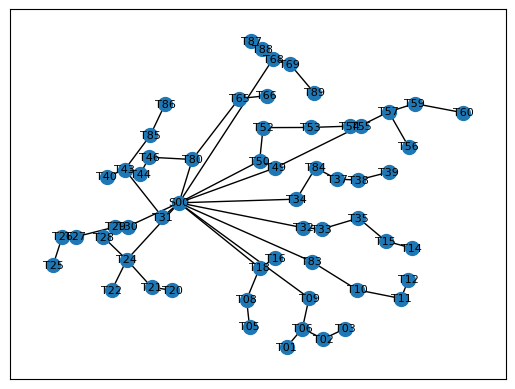

In [28]:
def find_mst_edges(point_list, graph):
    # Create a subgraph with the given points
    subgraph = graph.subgraph(point_list)
    
    # Find the MST of the subgraph
    mst = nx.minimum_spanning_tree(subgraph)
    
    # Extract edges from the MST
    mst_edges = []
    for u, v, data in mst.edges(data=True):
        mst_edges.append([u, v, data['weight']])
    
    return mst_edges

mst_collections = {key: find_mst_edges(points, G) for key, points in collection.items()}
G_mst = nx.Graph()
for k in mst_collections:
    G_mst.add_weighted_edges_from(mst_collections[k])

nx.draw_networkx(G_mst, pos=pos_dict, with_labels=True, node_size=100, font_size = 8)

# Calculate total weight
total_weight = 0
for k in mst_collections:
    for i in mst_collections[k]:
        total_weight += i[2]
total_weight *= 325000

print(f"Approx. Total Cable Length = {total_weight} ft ± 10%")
#print(mst_collections)

The load_calculator() function is used to calculate the number of WTG's descending from each line segment. This is important for the naming convention of line segments so that the cable schedule will autimatically size the cables.

In [29]:
def load_calculator(edges):
    Gx = nx.Graph()
    Gx.clear()
    
    # Add edges to the graph
    Gx.add_edges_from(edges)

    # Perform BFS starting from 'S00'
    tree = list(nx.dfs_edges(Gx, source='S00'))
    #print(tree)

    Gx.clear()
    Gx = nx.DiGraph()
    Gx.add_edges_from(tree)

    # Display the DFS traversal order
    dfs_order = [edge[1] for edge in tree]
    #print("DFS Traversal Order:", dfs_order)

    tree = [list(t) for t in tree]

    for i in dfs_order:
        for j in tree:
            if i == j[1]:
                descendants = len(nx.descendants(Gx,i)) + 1
                j.append(descendants)

    #print(tree)
    return tree

The load_calculator() function is applied to each segment.

In [31]:
# Copy mst collection, and replace distance with # of WTG's
kml_drawer = mst_collections

for k in kml_drawer:
    kml_drawer[k] = [item[:2] for item in kml_drawer[k]]
 
for k in kml_drawer:
    #print(kml_drawer[k])
    kml_drawer[k] = load_calculator(kml_drawer[k])
print(kml_drawer)

{'11A': [['S00', 'T09', 5], ['T09', 'T06', 4], ['T06', 'T02', 2], ['T02', 'T03', 1], ['T06', 'T01', 1]], '11B': [['S00', 'T18', 4], ['T18', 'T16', 1], ['T18', 'T08', 2], ['T08', 'T05', 1]], '12A': [['S00', 'T24', 5], ['T24', 'T28', 1], ['T24', 'T22', 1], ['T24', 'T21', 2], ['T21', 'T20', 1]], '12B': [['S00', 'T30', 5], ['T30', 'T29', 4], ['T29', 'T27', 3], ['T27', 'T26', 2], ['T26', 'T25', 1]], '13A': [['S00', 'T31', 5], ['T31', 'T43', 4], ['T43', 'T85', 2], ['T85', 'T86', 1], ['T43', 'T40', 1]], '13B': [['S00', 'T80', 5], ['T80', 'T46', 2], ['T46', 'T44', 1], ['T80', 'T65', 2], ['T65', 'T66', 1]], '21A': [['S00', 'T83', 4], ['T83', 'T10', 3], ['T10', 'T11', 2], ['T11', 'T12', 1]], '21B': [['S00', 'T32', 5], ['T32', 'T33', 4], ['T33', 'T35', 3], ['T35', 'T15', 2], ['T15', 'T14', 1]], '22A': [['S00', 'T34', 5], ['T34', 'T84', 4], ['T84', 'T37', 3], ['T37', 'T38', 2], ['T38', 'T39', 1]], '22B': [['S00', 'T49', 5], ['T49', 'T57', 4], ['T57', 'T59', 2], ['T59', 'T60', 1], ['T57', 'T56', 1]

**Create KML**

The kml_drawer and pos_dict data are used to draw line segments between points.

Folders are named after the feeder.

Line features are named "[Start point] [End point] [# of WTG's]" according to the cable schedule.

The output file will be located in the same folder. Running this script will overwrite the file, so rename it if you want to keep multiple drafts. 

In [11]:
import simplekml
kml = simplekml.Kml()

for layer_desc, lines in kml_drawer.items():
    # Create a folder for each layer
    folder = kml.newfolder(name=layer_desc)
    
    # Iterate over each line in the layer
    for line in lines:
        start, end, attribute = line
        # Get the coordinates from pos_dict
        start_coords = pos_dict[start]
        end_coords = pos_dict[end]
        
        # Create a linestring for each line
        linestring = folder.newlinestring(
            name=f"{start} {end} {attribute}",
            coords=[(start_coords[0], start_coords[1]), (end_coords[0], end_coords[1])]
        )
        
        # Add a description or other attributes if needed
        linestring.description = f"{layer_desc}"
        linestring.style.linestyle.color = simplekml.Color.red
        linestring.style.linestyle.width = 2

# Save the KML to a file
kml.save("output.kml")
